## Exploratory Data Analysis Code

This notebook can be used to analyze sequencing data directly without using a surrogate ML model.

Analyses include: 
1) Substrate specificity aka Y* score heatmaps 
2) S Score and Y* score calculations and plots
3) Hamming distance (library diversity) calculations

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm 
import os
from glob import glob
import matplotlib.pyplot as plt

from ..analysis import y_star_score
from ..analysis import s_score

In [5]:
# import selection peptides

def get_dataset(sel='./', anti='./', header=None):
    def get_df(location):
        if os.path.isdir(location):
            sdf = []
            files = [y for x in os.walk(location) for y in glob(os.path.join(x[0], '*.csv'))]
            if header is None:
                sdf = pd.concat([pd.read_csv(os.path.join(location, f), header=header) for f in files])
            else:
                sdf = pd.concat([pd.read_csv(os.path.join(location, f)) for f in files])
        else:
            if header is None:
                sdf = pd.read_csv(location, header=header)
            else:
                sdf = pd.read_csv(location)
        if header is None:
            sdf.columns = ['seq', None]
        sdf = sdf.drop_duplicates(subset=['seq'])
        return sdf

    sdf = get_df(sel)
    adf = get_df(anti)
    print('Unique peptides in sele (%s) and anti (%s) datasets!' % (str(sdf.shape[0]), str(adf.shape[0])))

    inter = np.intersect1d(sdf.seq.values, adf.seq.values)
    print('Intersection peptides:', inter.shape[0])
    sdf = sdf.loc[~sdf.seq.isin(inter)]
    adf = adf.loc[~adf.seq.isin(inter)]
    
    return sdf, adf

spath = '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/datasets/rd3/sele/'
apath = '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/datasets/rd3/anti/'

sel, anti = get_dataset(spath, apath, header=1)

/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/datasets/rd3/sele/ /proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/datasets/rd3/anti/
Unique peptides in sele (469867) and anti (491952) datasets!
Intersection peptides: 187


In [6]:
# get QC dataset
qc_path = '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/datasets/rd1/QC/ES-Ace_R1_001.csv'

qc = pd.read_csv(qc_path)
qc = qc.drop_duplicates(subset=['seq'])
qc

,ORF,round,seq,count,pct
0,ORF 1,1,MLAELSEEALIEGRGPNAGVCDGSGSYPYDVPDYAGSGSGS*,12,0.01%
1,ORF 2,1,MLAELSEEALIEGRSPVCLERVGSGSYPYDVPDYAGSGSGS*,11,0.00%
2,ORF 3,1,MLAELSEEALIEGRCSRRCAGVGSGSYPYDVPDYAGSGSGS*,10,0.00%
3,ORF 4,1,MLAELSEEALIEGRFSLCCVIFGSGSYPYDVPDYAGSGSGS*,10,0.00%
4,ORF 5,1,MLAELSEEALIEGRPVEYCTNDGSGSYPYDVPDYAGSGSGS*,10,0.00%
...,...,...,...,...,...
187423,ORF 187424,1,MLAELSEEALIEGRTMAHCPRDGSGSYPYDVPDYAGSGSGS*,1,0.00%
187424,ORF 187425,1,MLAELSEEALIEGRPVRLCAFAGSGSYPYDVPDYAGSGSGS*,1,0.00%
187425,ORF 187426,1,MLAELSEEALIEGRTLDSCAITGSGSYPYDVPDYAGSGSGS*,1,0.00%
187426,ORF 187427,1,MLAELSEEALIEGRIFAHCSNIGSGSYPYDVPDYAGIGSGS*,1,0.00%


In [7]:
"""
# trim out fixed regions to only include variable regions
indexing: 
    22-24: variable region 1

    25: target cysteine (fixed)
    26-28: variable region 2
"""

def trim_seq(df, pos_ranges=[[22, 25], [26, 29]]):
    if pos_ranges is None:
        df['var_seq'] = df['seq']
    elif len(pos_ranges) == 1:
        df['var_seq'] = df['seq'].str[pos_ranges[0][0]: pos_ranges[0][1]]
    else:
        df['var_seq'] = df['seq'].str[pos_ranges[0][0]: pos_ranges[0][1]] + df['seq'].str[pos_ranges[1][0]: pos_ranges[1][1]]
    return df
    
# for LynD NNK7
pr = [[14, 22]]
    
sel = trim_seq(sel, pr)
anti = trim_seq(anti, pr)
qc = trim_seq(qc, pr)

In [7]:

def filter_library(df, filter_seq='C1-4', flip=False):
    """Filter library according to amino acid presence at certain position(s)"""
    aa = filter_seq[0]
    pos = filter_seq[1:].split('-')
    pos = [int(p) for p in pos]

    mask = df['var_seq'].str[pos[0] - 1: pos[1]].str.contains(aa)

    if flip:
        return df.loc[mask].reset_index(drop=True)
    else:
       return df.loc[~mask].reset_index(drop=True)

# tag = 'C1-4'
# sel = filter_library(sel, tag, flip=False)
# anti = filter_library(anti, tag, flip=False)


In [8]:
# train/test split for Y-star / S-score calculation (optional)

from sklearn.model_selection import train_test_split
sel_train, sel_test = train_test_split(sel, test_size=0.10)
anti_train, anti_test = train_test_split(anti, test_size=0.10)


In [9]:
# calculate y_star score (relative enrichment of certain residue/position combos)

y_star = y_star_score(sel, anti)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [01:05<00:00,  8.24s/it]


Text(0, 0.5, 'Y* score (log2)')

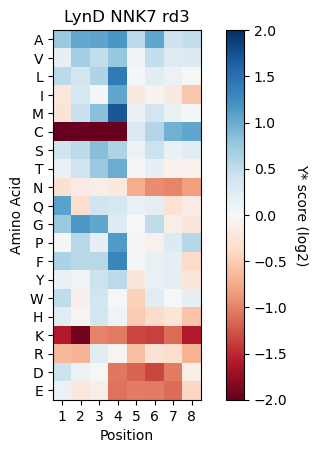

In [10]:
# plot as heatmap
alphabet = 'AVLIMCSTNQGPFYWHKRDE'

plt.imshow(np.log2(y_star.T), cmap='RdBu', vmin=-2, vmax=2)
plt.yticks(np.arange(len(alphabet)), alphabet)
plt.title('LynD NNK7 rd3')
plt.xticks(np.arange(y_star.shape[0]), np.arange(y_star.shape[0]) + 1)
plt.ylabel('Amino Acid')
plt.xlabel('Position')
cbar = plt.colorbar()

cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Y* score (log2)', rotation=270)


In [11]:
# save Y star score as csv file

# save_data = np.log2(y_star.T)
# save_df = pd.DataFrame(data=save_data, columns=np.arange(1, 9), index=[a for a in alphabet])
# save_df.to_csv('NNK7-YStar-rd3-C8.csv')

Text(0.5, 0, 'Threshold (S Score)')

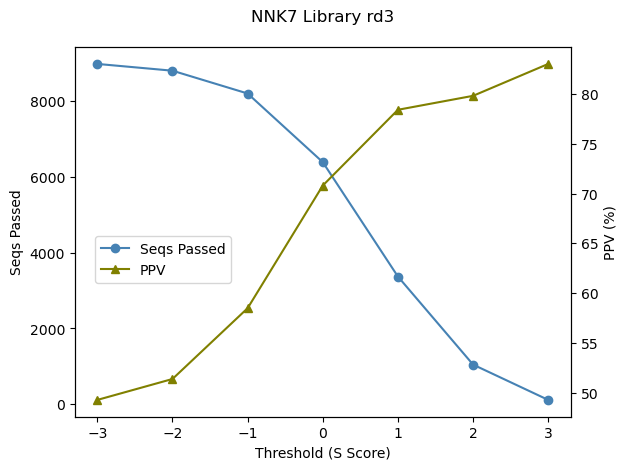

In [12]:
# make S Score plot

disp  = pd.DataFrame({
    'Seqs Passed': [8981, 8802, 8200, 6388, 3368, 1044, 112], 
    'Threshold': [-3, -2, -1, 0, 1, 2, 3], 
    'PPV': [49.3, 51.4, 58.5, 70.8, 78.4, 79.8, 83.0]
})

ax = disp.plot(x='Threshold', y='Seqs Passed', legend=False, color='steelblue', marker='o')
ax2 = ax.twinx()
disp.plot(x='Threshold', y='PPV', ax=ax2, legend=False, color='olive', marker='^')
ax.figure.legend(bbox_to_anchor=(0.38, 0.5, 0, 0))
plt.title('NNK7 Library rd3\n')
ax.set_ylabel('Seqs Passed')
ax2.set_ylabel('PPV (%)')
ax.set_xlabel('Threshold (S Score)')
# plt.savefig('NNK7-rd3-Sscore-PPV.pdf')
# plt.show()

In [13]:
# calculate S score for each peptide

s_sel = s_score(sel, y_star)
s_anti = s_score(anti, y_star)

# s_sel = s_score(sel_test, y_star)
# s_anti = s_score(anti_test, y_star)

s_qc = s_score(qc, y_star)

  2%|▏         | 7454/469680 [00:00<00:06, 74532.79it/s]

100%|██████████| 187428/187428 [00:01<00:00, 99188.89it/s] 


In [14]:
qc['S Score'] = s_qc
qc['Library'] = 'Naive'
sel['S Score'] = s_sel
sel['Library'] = 'Selection'
anti['S Score'] = s_anti
anti['Library'] = 'Antiselection'

combined = pd.concat([qc, sel, anti]).reset_index(drop=True)
combined['C1-C4'] = combined['var_seq'].str[:4].str.contains('C')
combined = combined.drop('round', axis=1)
# combined.to_csv('NNK7-updated-S-Scores.csv')


([<matplotlib.axis.XTick at 0x7fcff6656230>,
 [Text(-10, 0, '−10'), Text(-5, 0, '−5'), Text(0, 0, '0'), Text(5, 0, '5')])

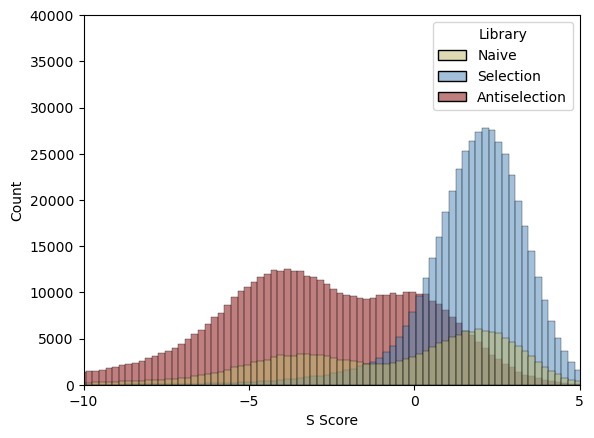

In [17]:
import seaborn as sns
pal = ['darkkhaki', 'steelblue', 'maroon'
]
disp = combined
# disp = combined.loc[combined['C1-C4']]
sns.histplot(disp, x='S Score', hue='Library', alpha=0.5, stat='count', binwidth=0.2, palette=pal)
plt.xlim(-10, 5)
plt.ylim(0, 40000)
plt.xticks([-10, -5, 0, 5])
# plt.savefig('NNK7-rd3-SScore-dist-QC.pdf')
# plt.savefig('NNK7-rd3-SScore-dist-QC-C1-C4.pdf')

mu1=[1.98154215], mu2=[-4.02775712]
sigma1=[[1.25179148]], sigma2=[[1.60093744]]
w1=0.5857469195903494, w2=0.4142530804096506
n1=45863 n2=45207


<Axes: >

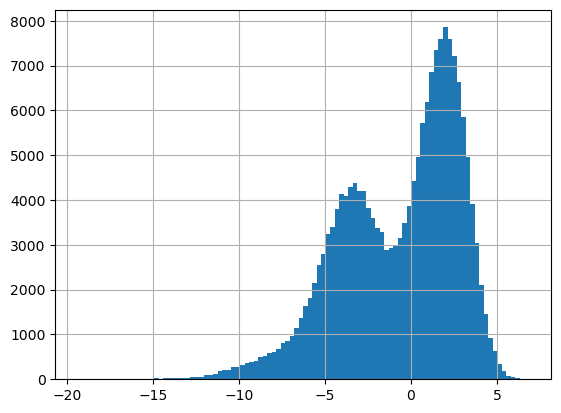

In [91]:
import numpy as np
from sklearn.mixture import GaussianMixture
from pylab import concatenate, normal


def get_params(df, mu_values, sigma_values, sample_values):
    # normal distribution parameters (estimated)
    if len(mu_values) == 1:
        mu = mu_values[0]
        sigma = sigma_values[0]
        n = sample_values[0]
        X = concatenate((normal(mu, sigma, n), normal(mu, sigma, n))).reshape(-1, 1)
        gm = GaussianMixture(n_components=1, random_state=0).fit(X)
        print(f'mu={gm.means_[0]}')
        print(f'sigma={np.sqrt(gm.covariances_[0])}')
        print(f'w={gm.weights_[0]}')
        print(f'n={int(n * gm.weights_[0])}')
    else:
        
        mu1, mu2 = mu_values # average
        sigma1, sigma2 = sigma_values # std dev
        n1, n2 = sample_values # num samples
        n = n1 + n2

        X = concatenate((normal(mu1, sigma1, n1), normal(mu2, sigma2, n2))).reshape(-1, 1)
        gm = GaussianMixture(n_components=2, random_state=0).fit(X)
        print(f'mu1={gm.means_[0]}, mu2={gm.means_[1]}')
        print(f'sigma1={np.sqrt(gm.covariances_[0])}, sigma2={np.sqrt(gm.covariances_[1])}')
        print(f'w1={gm.weights_[0]}, w2={gm.weights_[1]}')
        print(f'n1={int(n1 * gm.weights_[0])} n2={int(n2 * gm.weights_[1])}') 

# naive peaks (two)
# test = combined.loc[combined['Library'] == 'Naive']
# get_params(
#     df=test, 
#     mu_values=[-4, 2], 
#     sigma_values=[1.631696, 1.238101], 
#     sample_values=[78299, 109129]
# )
# test['S Score'].hist(bins=100)

# selection peak (one)
# test = combined.loc[combined['Library'] == 'Selection']
# get_params(
#     df=test, 
#     mu_values=[2.2], 
#     sigma_values=[1.65], 
#     sample_values=[test.shape[0]]
# )
# test['S Score'].hist(bins=100)

# antiselection peaks (two)
# test = combined.loc[combined['Library'] == 'Antiselection']
# get_params(
#     df=test, 
#     mu_values=[-4, 0], 
#     sigma_values=[2.397758, 1.166206], 
#     sample_values=[344237, 147528]
# )
# test['S Score'].hist(bins=100)


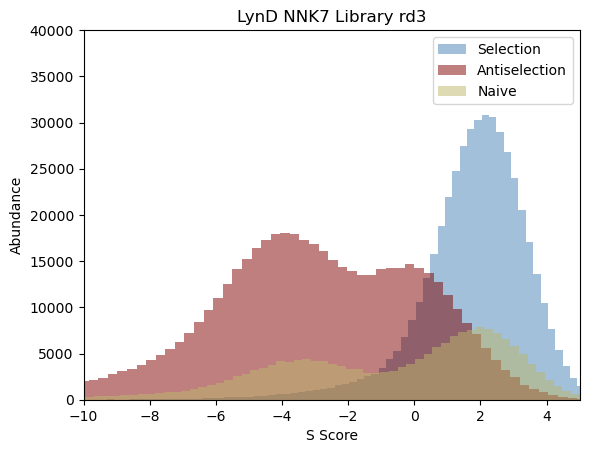

In [39]:
# plot  S Scores
plt.hist(s_sel, bins=100, color='steelblue', alpha=0.5)#, density=True)
plt.hist(s_anti, bins=100, color='maroon', alpha=0.5)#, density=True)
plt.hist(s_qc, bins=100, color='darkkhaki', alpha=0.5)
plt.xlim(-10, 5)
plt.ylim(0, 40000)
plt.title('LynD NNK7 Library rd3')
plt.xlabel('S Score')
plt.ylabel('Abundance')
plt.legend(['Selection', 'Antiselection', 'Naive'])
plt.savefig('NNK7-rd3-SScore-dist-QC.pdf')

In [ ]:
# threshold the S-score

df_sel = pd.DataFrame({
        'active': 1, 
        's_score': s_sel
    })
df_anti = pd.DataFrame({
    'active': 0, 
    's_score': s_anti
})

df = pd.concat([df_sel, df_anti], axis=0).reset_index(drop=True)

from sklearn.metrics import roc_curve
fpr, tpr, thresh = roc_curve(df.active.values, df.s_score.values)
idx = np.argmax(tpr - fpr)
opt_thr = thresh[idx]

In [ ]:
# CUSTOM = 1
CUSTOM = opt_thr
pred_pos = df.loc[df.s_score > CUSTOM] # keep only those with S-score above threshold ("predicted positives")
frac = pred_pos.loc[pred_pos.active == 1].shape[0] / pred_pos.shape[0] # get fraction of "true positives" vs total
num = pred_pos.loc[pred_pos.active == 1].shape[0]
print('TOTAL PEPTIDES:', num, '\nFPR:', frac)

In [ ]:
pred_active = df.s_score > opt_thr

from sklearn.metrics import accuracy_score, balanced_accuracy_score
accuracy_score(df.active, pred_active), balanced_accuracy_score(df.active, pred_active)

In [ ]:
# ---------- Hamming Distance ------------ #

from scipy.spatial.distance import hamming 


def hamming_lib(df, sub=0.1):
    """
    Calculates Hamming distance of all-vs-all for a peptide library as a rough seq diversity metric
    Note: this currently runs VERY slowly and can't handle more than a few thousand seqs
    """
    
    seqs = df.seq.values
    siz = round(seqs.shape[0] * sub)
    seqs = np.random.choice(seqs, siz)
    print(seqs.shape)
    ham_list = []
    for s1 in tqdm(seqs):
        for s2 in seqs:
            if s1 != s2:
                ham = hamming(list(s1), list(s2)) * len(s1)
                ham_list.append(ham)
    return ham_list

hams = hamming_lib(sel, 0.01)

